In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

def readPd(filename):
    df = pd.read_csv(filename)
    # Read as scientific notation
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

In [29]:
def plotBodeMC(frec, loglog=[], semilog=[]):
    # check if plot_data is a list
    if not isinstance(loglog, list):
        loglog = [loglog]
    if not isinstance(semilog, list):
        semilog = [semilog]

    # Create a figure and two axes
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    cmap =  plt.cm.viridis(np.linspace(0, 1, len(frec)))
    ax1.set_prop_cycle('color', cmap)
    ax2.set_prop_cycle('color', cmap)

    for y1 in loglog:
        ax1.loglog(frec, y1, lw=1.5, linestyle='-', alpha=0.8)
    for y2 in semilog:
        ax2.semilogx(frec, y2, lw=1.5, linestyle='--', alpha=0.5)

    ax1.set_ylabel('LogLog', color='black')
    ax2.set_ylabel('Semilog', color='black')

    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, which="both", ls="-", axis="x")
    ax1.grid(True, which="both", ls="-", axis="y")

    ax2.tick_params(axis='y', labelcolor='black')
    ax2.grid(True, which="major", ls="-")

    ax1.xaxis.set_minor_locator(plt.LogLocator(base=10, subs='all', numticks=400))
    ax1.xaxis.set_major_locator(plt.LogLocator(base=10, numticks=100))

    # set ticks for ax2 y axis
    ax2.yaxis.set_major_locator(plt.MultipleLocator(100))
    # ax1.yaxis.set_major_locator(plt.MultipleLocator(20))

    ax1.set_xlabel('Frecuencia $[Hz]$')

    # set axis limits
    ax1.set_xlim(left=min(frec), right=max(frec))
    plt.show()

In [4]:

df = readPd('L_HP.csv')
# reinterpret as float
df = df.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Frecuencia  16 non-null     float64
 1   L[mH]       16 non-null     float64
 2   Q           16 non-null     float64
 3   Rs[Ohm]     16 non-null     float64
 4   |Z|         16 non-null     float64
 5   Fase        16 non-null     float64
dtypes: float64(6)
memory usage: 896.0 bytes


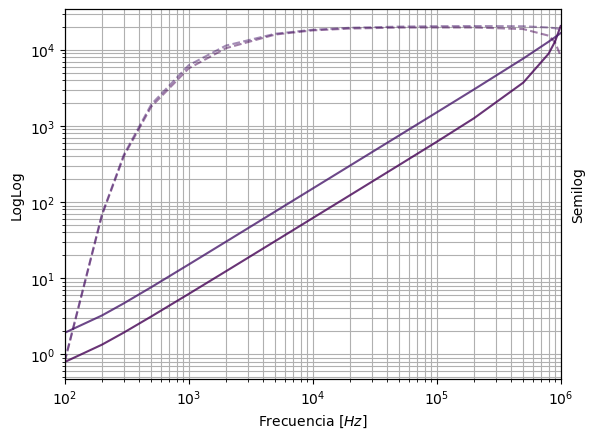

R^2 = 0.9103518066064852
popt = [2.39613000e-03 1.18109748e+00 1.00000000e-12 1.00000000e+04]


In [52]:
# define the true objective function
def parallelZ(A, B):
	return (A*B) / (A + B)

def parallelABC(A, B, C):
    return (A*B*C) / (A*B + A*C + B*C)

def Impedance(f, L, Rl, C, Rc):
    s = 1j*2*np.pi*f
    
    # lr = parallelZ(L, Rac)
    # Z = 1/(s*C) + Rl + s*L  # ANDA BIEN
    # Z = parallelZ(1/(s*C), Rc) + Rl + s*L  # ANDA BIEN
    # Z = Rl + s*L 
    Z = parallelZ(Rl + s*L, Rc + 1/(s*C))  # ANDA BIEN 

    mod_phase = np.concatenate((np.abs(Z), np.angle(Z, deg=True)))
    return mod_phase

f = df['Frecuencia']
y_data = np.concatenate((df['|Z|'], df['Fase']))

# curve fit
p0 = [0.00239613, 1.18109748, 1e-12, 1e4]
popt, _ = curve_fit(Impedance, f, y_data, p0=p0, method='lm', maxfev=100000000)
# summarize the parameter values
# L, Rs, C = popt

y_curve = Impedance(f, *popt)
mod_curve, phase_curve = y_curve[:len(y_curve)//2], y_curve[len(y_curve)//2:]

# plot input vs output
plotBodeMC(f, loglog=[df['|Z|'], mod_curve], semilog=[df['Fase'], phase_curve])

residuals = y_data - y_curve
ss_res = np.sum(residuals**2)
ss_tot = np.sum( (y_data - np.mean(y_data))**2 )
r_2 = 1 - (ss_res / ss_tot)

print("R^2 =", r_2)
print("popt =", popt)